# Stanford Cars Dataset Make&Brand Classfication

# 1 Summary

Stanford Cars dataset is a labelled dataset in the domain of cars. It has 196 classes and 16185 labelled images. In this notebook, Facebook's ResNext model is trained and tuned to classify cars' make&brand. 

Eventually, the testing top-1 accuracy of **90.98%** and testing top-5 accuracy of **98.56%** are achieved.

Contents
* Download
* Preprocessing
    * split into folders by classes
    * multi-crop
    * augmentation
* Train
    * train last layer
    * fine tune
    * train last layer with higher resolution
* Evaluation
    * evaluation training result
    * run the model on the test dataset
    * run the model on the preprocessed test dataset

### Tuning techniques used:
1. 1cycle policy (https://arxiv.org/pdf/1803.09820.pdf)
2. fine tune existing pretrained deep learning models
3. use multi-cropped training images, preprocess test images by multi-cropping and essemble the result.
4. learning rate finding (https://arxiv.org/abs/1506.01186)
5. use higher resolution images to retrain the model's last layer

### Possible further improvement:
1. apply batch normalization (https://arxiv.org/pdf/1902.06550.pdf)
2. apply images' bbox + single shot detection
3. use domain knowledge pretrained models (https://openreview.net/pdf?id=HyxH2o05FQ)
4. apply mixup (https://arxiv.org/abs/1710.09412)
5. train deeper NN, eg. ResNet152
6. replace matplot with opencv to accelerate image reading
7. replace loops with DataFrame operations which is backboned by C (strong type vs dynamic type)

# 2 Import packages

In [1]:
import pretrainedmodels
from fastai.vision import *
import os
from scipy.io import loadmat
import pandas as pd
from shutil import copyfile
import shutil
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
NB_PATH = !pwd
NB_PATH = NB_PATH[0]
MODULE_BASE = 'full-crop-resnext101'
NB_PATH, MODULE_BASE

('/Users/young/Develop/workspace/Stanford Cars Classification',
 'full-crop-resnext101')

# 3 Download data

In [ ]:
untar_data('http://imagenet.stanford.edu/internal/car196/car_ims', 
           fname=NB_PATH + '/dataset/car_ims.tgz', 
           dest=NB_PATH + '/dataset/', 
           data=True
)

download_data('http://imagenet.stanford.edu/internal/car196/cars_annos', 
               fname=NB_PATH + '/dataset/cars_annos.mat',
               ext='.mat'
)

# 4 Preprocessing

### 4.1 Load annotations

In [4]:
def load_annos(df_annos_raw, columns):
    return pd.DataFrame(
        [
            [e.flat[0] for e in line] for line in df_annos_raw
        ], 
        columns=columns
    )

df_label = loadmat('./dataset/cars_annos.mat')['class_names'][0]

df_annos_raw = loadmat('./dataset/cars_annos.mat')['annotations'][0]
annos_columns = ['fname', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'label_idx', 'train_test']

df_annos = load_annos(df_annos_raw, annos_columns)
df_annos['fname'] = df_annos['fname'].str.slice(8,)
df_annos['label_idx'] = df_annos['label_idx'] - 1
df_annos['label'] = df_label[df_annos['label_idx']]
df_annos['label'] = df_annos['label'].apply(lambda x: x[0])
df_annos.head()

,fname,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label_idx,train_test,label
0,000001.jpg,112,7,853,717,0,0,AM General Hummer SUV 2000
1,000002.jpg,48,24,441,202,0,0,AM General Hummer SUV 2000
2,000003.jpg,7,4,277,180,0,0,AM General Hummer SUV 2000
3,000004.jpg,33,50,197,150,0,0,AM General Hummer SUV 2000
4,000005.jpg,5,8,83,58,0,0,AM General Hummer SUV 2000


### 4.2 Split dataset

Split images into train:valid:test = 70:15:15

In [5]:
IMG_CNT = df_annos.fname.count()
TRAIN_CNT = int(IMG_CNT * 0.7)
VALID_CNT = int(IMG_CNT * 0.15)
TEST_CNT = IMG_CNT - TRAIN_CNT - VALID_CNT
IMG_CNT, TRAIN_CNT, VALID_CNT, TEST_CNT

(16185, 11329, 2427, 2429)

Split images into the following folder structure:

Shuffle dataset with a seed, so that we can reproduce the same result.

In [7]:
df_annos_sf = shuffle(df_annos, random_state=0)
df_annos_sf = df_annos_sf.reset_index(drop=True)
df_annos_sf.head()

,fname,bbox_x1,bbox_y1,bbox_x2,bbox_y2,label_idx,train_test,label
0,013156.jpg,25,32,236,180,160,0,Mercedes-Benz 300-Class Convertible 1993
1,010436.jpg,14,90,490,320,126,0,Honda Odyssey Minivan 2007
2,013712.jpg,213,158,906,618,166,1,Mitsubishi Lancer Sedan 2012
3,006420.jpg,37,79,825,391,78,1,Chrysler 300 SRT-8 2010
4,011988.jpg,60,82,483,387,145,1,Jeep Wrangler SUV 2012


In [ ]:
def copy_file(folder_by_classes, folder_origin, annos, start, cnt):
    if not os.path.exists(folder_by_classes):
        os.makedirs(folder_by_classes)
    else:
        shutil.rmtree(folder_by_classes)
    for i in range(len(annos)):
        if i < start or i >= start + cnt:
            continue
        folder_target = folder_by_classes + '/' + str(annos['label_idx'][i])
        if not os.path.exists(folder_target):
            os.makedirs(folder_target)
        img_origin_path = folder_origin + '/' + annos['fname'][i]
        img_target_path = folder_target + '/' + annos['fname'][i]
        if not os.path.exists(img_target_path):
            copyfile(img_origin_path, img_target_path)

copy_file('./dataset/split2/train', './dataset/car_ims', df_annos_sf, 0, TRAIN_CNT)
copy_file('./dataset/split2/valid', './dataset/car_ims', df_annos_sf, TRAIN_CNT, VALID_CNT)
copy_file('./dataset/split2/test', './dataset/car_ims', df_annos_sf, TRAIN_CNT + VALID_CNT, TEST_CNT)

### 4.3 Generate multi-cropped images for training

After several trials with different resize methods, such as crop(center), pad and squish, an new resize technique called Multi-crop is decided to use. Multi-crop technique is a preprocessing method to crop a image into three square images. For example:

Before crop:

!['origin'](dataset/car_ims/000002.jpg)

After crop:

Left:!['east'](dataset/split2/train/0/east_000002.jpg) 
Center:!['center'](dataset/split2/train/0/center_000002.jpg) 
Right:!['west'](dataset/split2/train/0/west_000002.jpg)

In [29]:
def multi_crop(img, width, height):
    img_east = img[0:height, 0:height, :] if len(img.shape) == 3 else img[0:height, 0:height]
    img_center = img[0:height, int(width/2-height/2):int(width/2+height/2), :] if len(img.shape) == 3 else img[0:height, int(width/2-height/2):int(width/2+height/2)]
    img_west = img[0:height, width-height:width, :] if len(img.shape) == 3 else img[0:height, width-height:width]
    return [img_east, img_center, img_west]


multi_crop_folder = NB_PATH + '/dataset/split2/train/'
if not os.path.exists(multi_crop_folder):
    os.makedirs(multi_crop_folder)

for index, row in df_annos_sf.iterrows():
    if index >= TRAIN_CNT:
        break
    fname = row.fname
    label_idx = str(row.label_idx)
    class_folder = multi_crop_folder + label_idx + '/'
    if not os.path.exists(class_folder + 'east_' + fname):
        img = plt.imread(class_folder + fname)
        shape = img.shape
        height = shape[0]
        width = shape[1]
        # swap width and height if height > width
        if width < height:
            tmp = height
            height = width
            width = tmp

        [img_east, img_center, img_west] = multi_crop(img, width, height)
    
        plt.imsave(class_folder + 'east_' + fname, img_east)
        plt.imsave(class_folder + 'center_' + fname, img_center)
        plt.imsave(class_folder + 'west_' + fname, img_west)
        os.remove(class_folder + fname)

### 4.4 Load image data bunch

#### 4.4.1 Load training data
The default argumentation of fastai turns out to be the best one after several trails.

In [47]:
data = ImageDataBunch.from_folder('./dataset/split2',
                                  # default argumentation: 
                                  # do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, 
                                  # max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  # batch size=32 is chosen to avoid OOM problem
                                  bs=32
                                 )

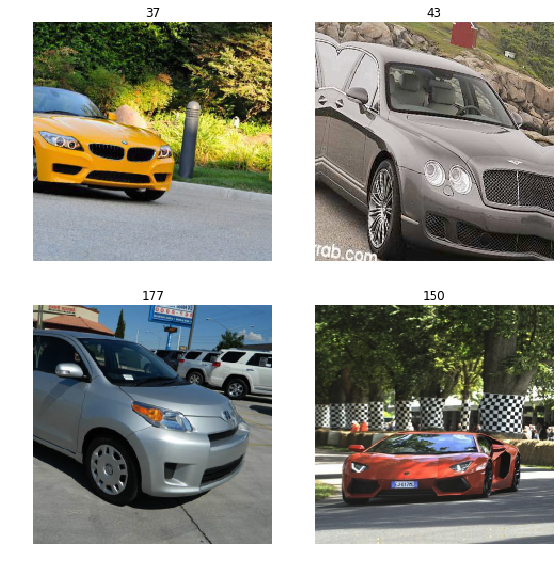

In [5]:
data.normalize(data.batch_stats())
data.show_batch(rows=2)

#### 4.4.2 Load higher resolution data

In [48]:
data_256 = ImageDataBunch.from_folder('./dataset/split2',
                                      # size can be larger to achieve higher performance, but due to limitation of the GPU, 256 is chosen.
                                      size=256,
                                      bs=32
                                     )

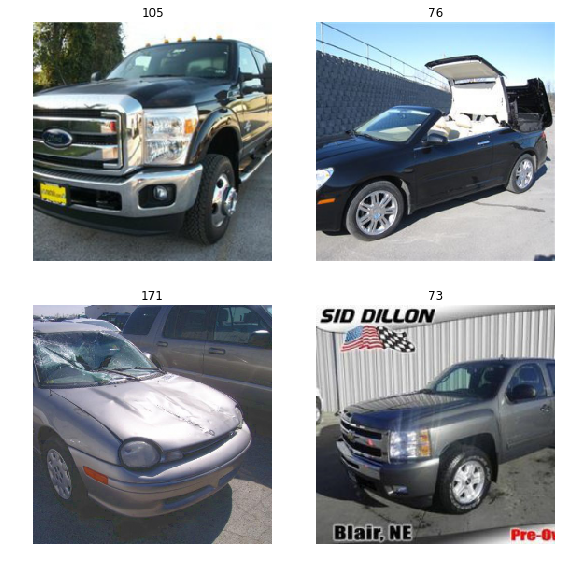

In [49]:
data_256 = data_256.normalize(data_256.batch_stats())
data_256.show_batch(rows=2)

#### 4.4.3 Load test data

In [10]:
data_test = ImageDataBunch.from_folder('./dataset/split2',
                                       train='test',
                                       size=256,
                                       bs=32
                                      )

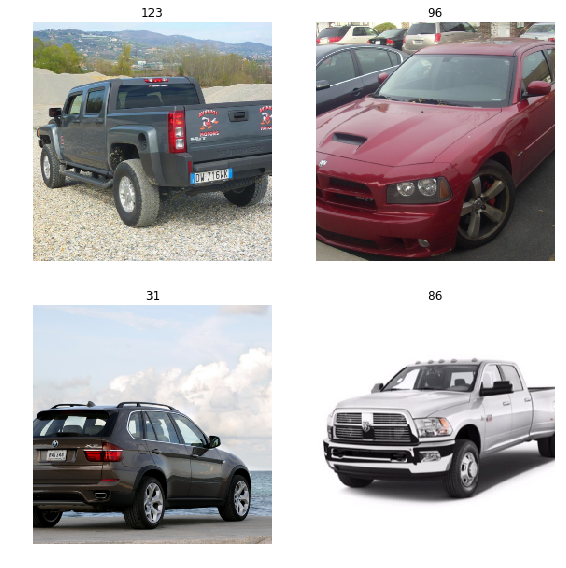

In [11]:
data_test = data_test.normalize(data_test.batch_stats())
data_test.show_batch(rows=2)

# 5 Train

## 5.1 Initialize model: resnext101_32x4d

In [6]:
def model_f(pretrained=True, **kwargs):
    return pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained='imagenet')

In [11]:
learn = cnn_learner(data, 
                    model_f, 
                    pretrained=True, 
                    metrics=[accuracy], 
                    model_dir=NB_PATH+"/model/", 
                    callback_fns=ShowGraph
                   )

## 5.2 Train the last layer

Firstly, we use learner finder to find the proper max learner according to the 1cycle policy training technique.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


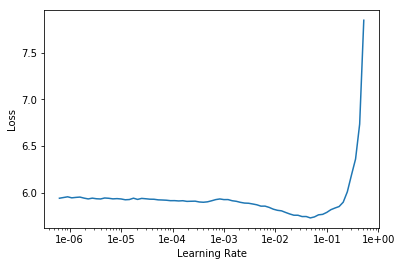

In [13]:
learn.recorder.plot()

From the plot, we can decide the best max_lr=1e-2 which has the sharpest slope.

epoch,train_loss,valid_loss,accuracy,time
0,2.089625,1.593940,0.592501,25:05
1,1.420648,0.907338,0.742480,24:59
2,0.875970,0.641575,0.824887,24:57
3,0.507820,0.424458,0.877627,25:02
4,0.330228,0.376891,0.892460,25:01


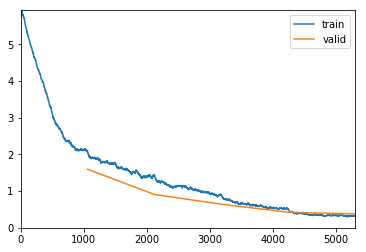

In [14]:
learn.fit_one_cycle(5, max_lr=1e-2)

Plot learning rate and momentum.

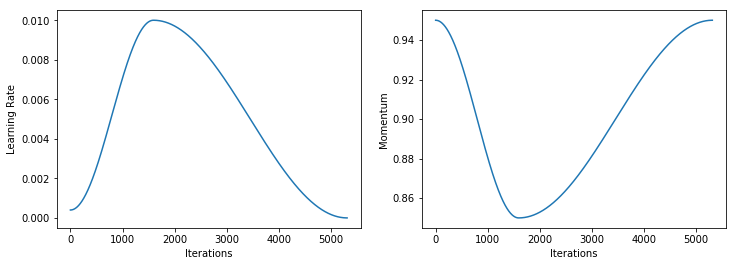

In [17]:
learn.recorder.plot_lr(show_moms=True)

We save the model so that we can resume the model.

In [18]:
learn.save(MODULE_BASE+'-stg1')
learn.export(NB_PATH+'/model/'+MODULE_BASE+'-stg1.pkl')

### 5.3 Fine tune

In the fine tune stage, we unfreeze the ResNext model and find the best max learning rate again using learning rater finder.

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


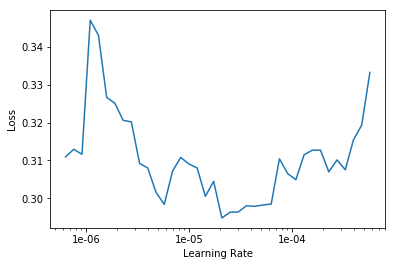

In [22]:
#learn.load('full-resnext101-stg1')
learn.lr_find()
learn.recorder.plot()

Train.

epoch,train_loss,valid_loss,accuracy,time
0,0.336121,0.367920,0.893696,33:37
1,0.263732,0.359217,0.899052,33:40


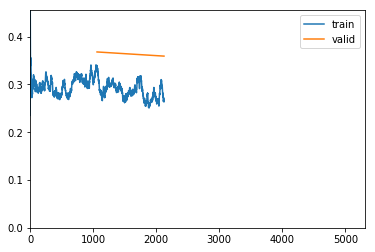

In [ ]:
# max_lr = slice(start, stop, step)
learn.fit_one_cycle(5, max_lr=slice(2e-6,3e-4))

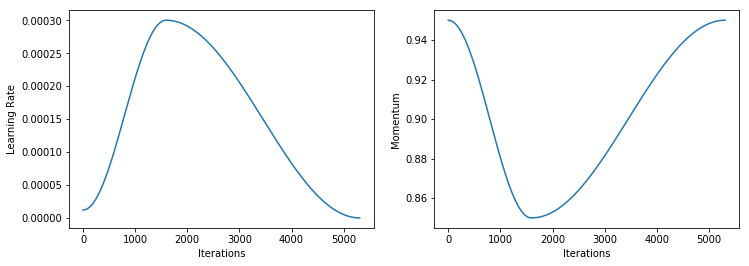

In [25]:
learn.recorder.plot_lr(show_moms=True)

In [26]:
learn.save(MODULE_BASE+'-stg2')
learn.export(NB_PATH+'/model/'+MODULE_BASE+'-stg2.pkl')

### 5.4 Train the last layer by higher resolution dataset

In this stage, we freeze the model and train the last layer with higher resolution images. Due to the limitation of my GPU's small memory, I have to set the image size to 256x256 only, but it still helps improve the model.

In [30]:
learn.data = data_256
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


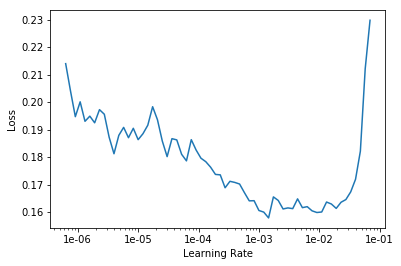

In [31]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.157260,0.318424,0.908941,29:39
1,0.170175,0.308240,0.912237,29:18
2,0.132984,0.310806,0.908529,29:20
3,0.145738,0.314381,0.908529,29:19


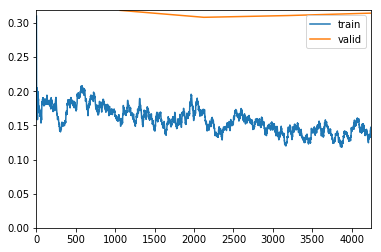

In [32]:
# slice(start, stop, step)
learn.fit_one_cycle(4, max_lr=2e-4)

In [35]:
learn.save(MODULE_BASE+'-stg3')
learn.export(NB_PATH+'/model/'+MODULE_BASE+'-stg3.pkl')

# 6 Evaluation

### 6.1 Evaluate learner

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

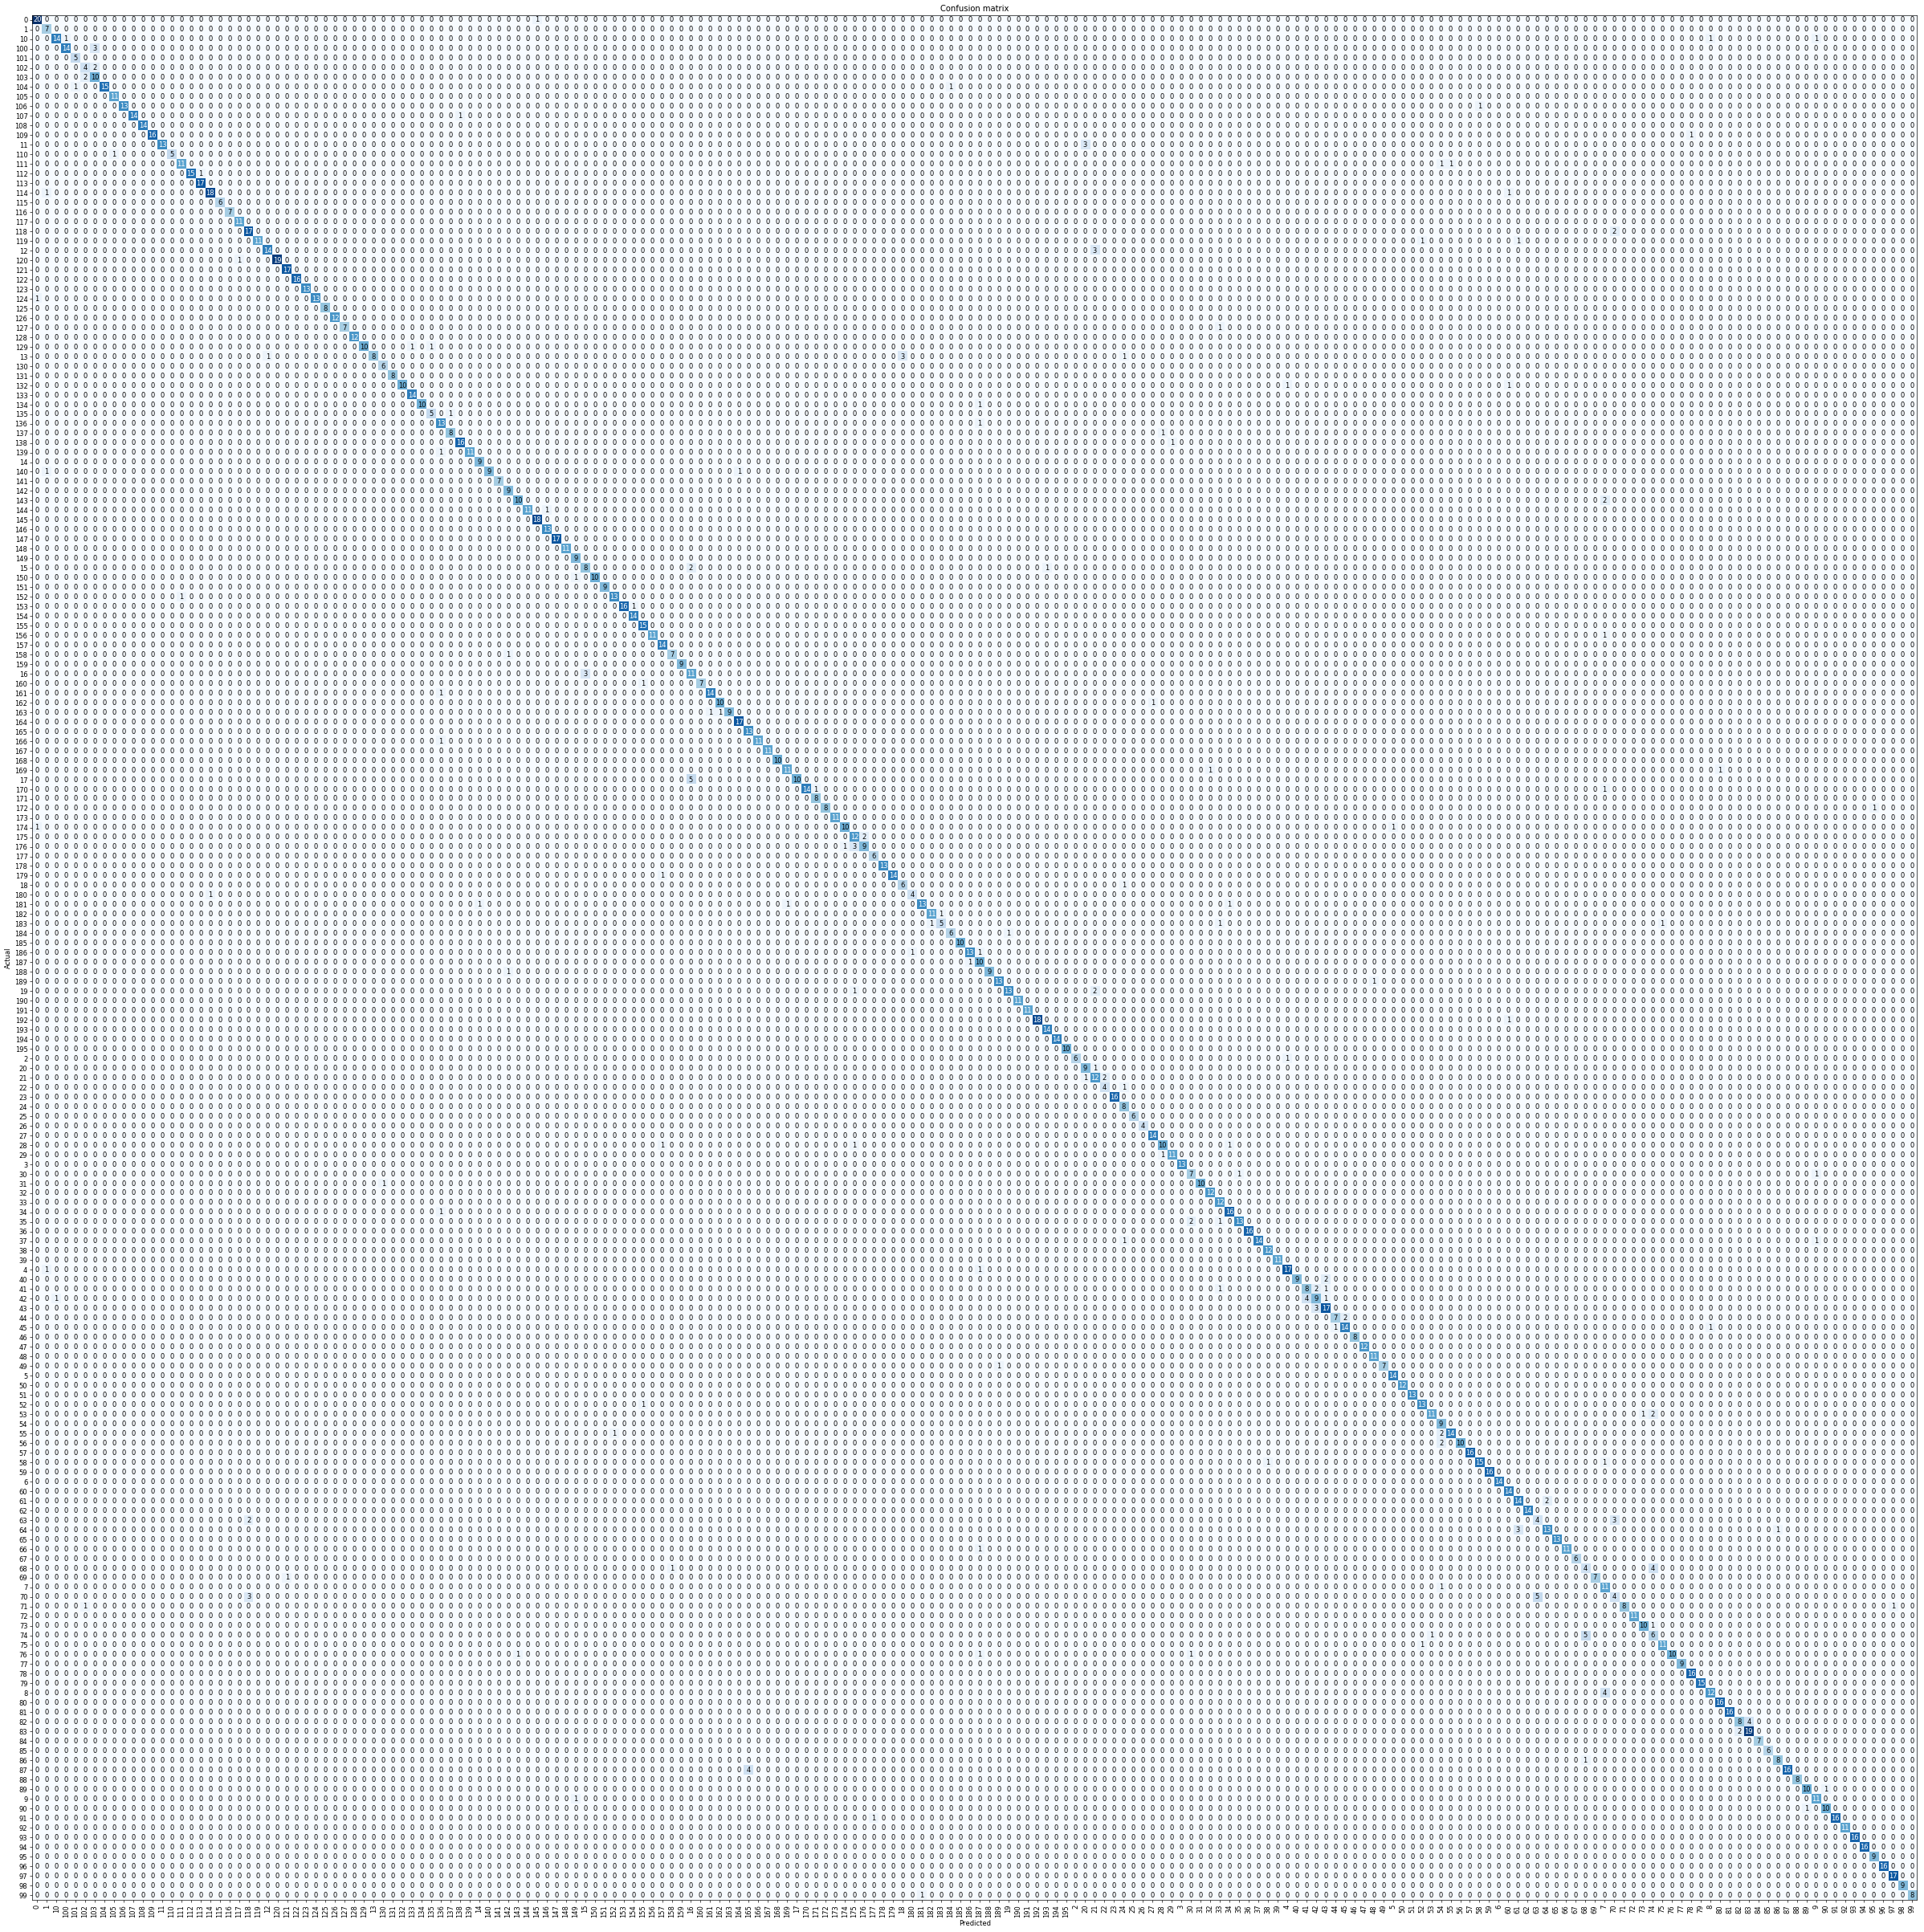

In [39]:
interp.plot_confusion_matrix(figsize=(40,40), dpi=60)

In [40]:
interp.most_confused(2)

[('17', '16', 5),
 ('70', '63', 5),
 ('74', '68', 5),
 ('42', '41', 4),
 ('68', '74', 4),
 ('8', '7', 4),
 ('82', '83', 4),
 ('87', '165', 4),
 ('100', '103', 3),
 ('11', '20', 3),
 ('12', '21', 3),
 ('13', '18', 3),
 ('16', '15', 3),
 ('176', '175', 3),
 ('43', '42', 3),
 ('63', '70', 3),
 ('64', '61', 3),
 ('70', '118', 3),
 ('102', '103', 2),
 ('103', '102', 2),
 ('118', '70', 2),
 ('143', '7', 2),
 ('15', '16', 2),
 ('175', '176', 2),
 ('19', '21', 2),
 ('21', '22', 2),
 ('35', '30', 2),
 ('40', '43', 2),
 ('41', '42', 2),
 ('44', '45', 2),
 ('53', '74', 2),
 ('55', '54', 2),
 ('56', '54', 2),
 ('61', '64', 2),
 ('63', '118', 2),
 ('83', '82', 2)]

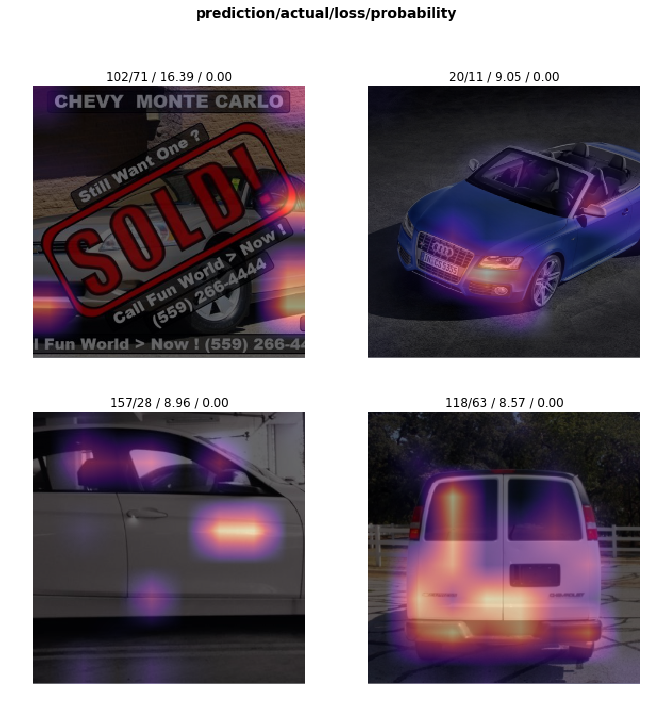

In [57]:
interp.plot_top_losses(4, figsize=(11,11), heatmap=True)

### 6.2 Run the final model on the test data

#### 6.2.1 Run the model on the raw test data.

In [9]:
learn_test = load_learner(NB_PATH+'/model', MODULE_BASE+'-stg3.pkl')

The test accuracy is 90.41%.

In [80]:
learn_test.validate(data_test.train_dl)

[0.39769173, tensor(0.9042)]

#### 6.2.1 Preprocess test data and run test by ensembling multi-crop images

Multi-crop test data.

In [182]:
def multi_crop(img, width, height):
    img_east = img[0:height, 0:height, :] if len(img.shape) == 3 else img[0:height, 0:height]
    img_center = img[0:height, int(width/2-height/2):int(width/2+height/2), :] if len(img.shape) == 3 else img[0:height, int(width/2-height/2):int(width/2+height/2)]
    img_west = img[0:height, width-height:width, :] if len(img.shape) == 3 else img[0:height, width-height:width]
    return [img_east, img_center, img_west]

multi_crop_folder = NB_PATH + '/dataset/split2/test_crop/'
if not os.path.exists(multi_crop_folder):
    os.makedirs(multi_crop_folder)

for index, row in df_annos_sf.iterrows():
    if index <= TRAIN_CNT + VALID_CNT:
        continue
    fname = row.fname
    label_idx = str(row.label_idx)
    img = plt.imread(NB_PATH + '/dataset/split2/test/' + label_idx + '/' + fname)
    shape = img.shape
    height = shape[0]
    width = shape[1]
    # swap width and height if height > width
    if width < height:
        tmp = height
        height = width
        width = tmp
    
    [img_east, img_center, img_west] = multi_crop(img, width, height)
    
    class_folder_east = multi_crop_folder + 'east/' + label_idx
    class_folder_center = multi_crop_folder + 'center/' + label_idx
    class_folder_west = multi_crop_folder + 'west/' + label_idx
    os.makedirs(class_folder_east, exist_ok=True)
    os.makedirs(class_folder_center, exist_ok=True)
    os.makedirs(class_folder_west, exist_ok=True)
    plt.imsave(class_folder_east + '/' + fname, img_east)
    plt.imsave(class_folder_center + '/' + fname, img_center)
    plt.imsave(class_folder_west + '/' + fname, img_west)

In [22]:
# The prediction is based on digits' alphabet order, so we need to decode predicted index to the actual label index.
def decode_pred_to_label(pred_idx):
    return int(sorted([str(x) for x in range(196)])[pred_idx])

def get_pred(learn, item):
    batch = learn.data.one_item(item)
    pred = learn.pred_batch(batch=batch)
    pred_np = to_np(pred).T
    pred_df = pd.DataFrame(pred_np)
    pred_sort = pred_df[0].sort_values(ascending=False)[:5]
    return [(decode_pred_to_label(index), prob) for index, prob in pred_sort.iteritems()]

Predict for all cropped datasets. QPS is 6 pred/s, which is quite good.

In [51]:
preds_multi = []
for crop in ['east', 'center', 'west']:
    data_folder = NB_PATH + '/dataset/split2/test_crop/' + crop
    data_test_crop = ImageDataBunch.from_folder(data_folder ,
                                                valid_pct=0,
                                                size=256,
                                                bs=32
                                               )
    data_test_crop = data_test_crop.normalize(data_test_crop.batch_stats())
    preds = []
    cnt = 0
    for img in data_test_crop.train_ds:
        preds.append(get_pred(learn_test, img[0]))
        cnt += 1
        if cnt % 500 == 0:
            print('{} predictions complete for crop dataset: {}.'.format(cnt, crop))
    preds_multi.append(preds)

250 predictions are done for crop: east.
500 predictions are done for crop: east.
750 predictions are done for crop: east.
1000 predictions are done for crop: east.
1250 predictions are done for crop: east.
1500 predictions are done for crop: east.
1750 predictions are done for crop: east.
2000 predictions are done for crop: east.
2250 predictions are done for crop: east.
250 predictions are done for crop: center.
500 predictions are done for crop: center.
750 predictions are done for crop: center.
1000 predictions are done for crop: center.
1250 predictions are done for crop: center.
1500 predictions are done for crop: center.
1750 predictions are done for crop: center.
2000 predictions are done for crop: center.
2250 predictions are done for crop: center.
250 predictions are done for crop: west.
500 predictions are done for crop: west.
750 predictions are done for crop: west.
1000 predictions are done for crop: west.
1250 predictions are done for crop: west.
1500 predictions are done

Get best prediction for each image from different crop dataset.

In [64]:
preds_best = []
for i in range(len(preds_multi[0])):
    preds_multi_top1 = [preds_multi[0][i][0][1], preds_multi[1][i][0][1], preds_multi[2][i][0][1]]
    selection = preds_multi_top1.index(max(preds_multi_top1))
    preds_best.append(preds_multi[selection][i])

In [87]:
facts = [img[1].obj for img in data_test_crop.train_ds]

In [92]:
match_cnt = 0
for i in range(len(facts)):
    if int(facts[i]) == preds_best[i][0][0]:
        match_cnt += 1

In [93]:
match_cnt_top5 = 0
for i in range(len(facts)):
    if int(facts[i]) in [x[0] for x in preds_best[i]]:
        match_cnt_top5 += 1

The essembled test accuracy is **90.98%**.

In [94]:
accuracy = match_cnt / len(facts)
accuracy

0.9098023064250412

The essembled top-5 test accuracy is **98.56%**.

In [95]:
accuracy = match_cnt_top5 / len(facts)
accuracy

0.9855848434925865

Save test data labels sorted by file names.

In [34]:
with open('test_label_sort_by_name.txt', 'w') as f:
    f.write('\n'.join(str(x) for x in df_annos_sf[['fname', 'label_idx']][TRAIN_CNT + VALID_CNT: IMG_CNT]\
        .sort_values(by=['fname']).reset_index(drop=True)['label_idx'].values.tolist()))